## Modelo ML

##### Librerias y limpieza

In [ ]:
#Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

url= 'https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv'
df = pd.read_csv(url, sep=';', encoding='utf-8', quotechar='"')
target ='y'

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10968
           1       0.44      0.89      0.59      1389

    accuracy                           0.86     12357
   macro avg       0.71      0.87      0.75     12357
weighted avg       0.92      0.86      0.88     12357

ROC-AUC: 0.9397327863661497


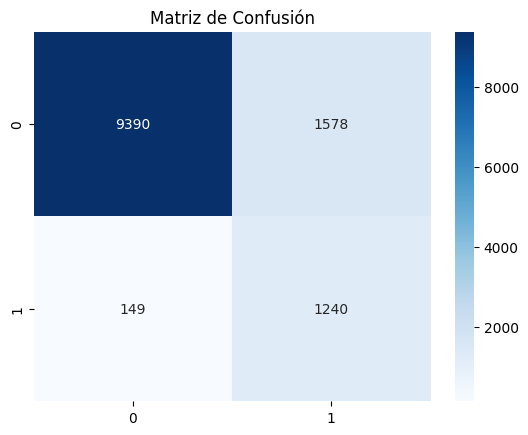

In [ ]:
#Train / test
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == 'yes' else 0)

num_features = X.select_dtypes(include=['int64','float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
# Escalado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=5000, class_weight='balanced'))
])
# Divido el en train y test al 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

# ENTRENAR MODELO
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.show() 


In [20]:
#optimizacion del modelo
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['lbfgs'],
    'logreg__penalty': ['l2']
}
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor AUC:", grid.best_score_)

Mejores parámetros: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Mejor AUC: 0.9356567096048043


In [22]:
# Obtengo nombres de features finales ONE-HOT (tras el ColumnTransformer)
ohe = model.named_steps['preprocess'].named_transformers_['cat']
ohe_cols = list(ohe.get_feature_names_out(cat_features))
final_cols = list(num_features) + ohe_cols

# Obtengo coeficientes
coef = model.named_steps['logreg'].coef_[0]
odds = np.exp(coef)

# Creo tabla ordenada
importance = pd.DataFrame({'feature': final_cols, 'odds_ratio': odds})
importance = importance.sort_values(by='odds_ratio', ascending=False)
importance.head(15)

,feature,odds_ratio
8,euribor3m,12.254843
42,month_mar,6.293081
6,cons.price.idx,5.532692
1,duration,4.436620
38,month_aug,2.296725
52,poutcome_success,2.191675
27,education_illiterate,1.664496
51,poutcome_nonexistent,1.557297
17,job_student,1.400698
45,month_oct,1.319106
